## spatial selection 

this notebook demonstrates how to select sky regions use healpy and interactive tools

- [polygon](#select-polygon)
- [disc](#select-disc)
- [ring](#select-ring)
- [ellipse](#select-ellipse)
- [Galactic avoidance region](#galactic-plane)
- [Ecliptic region](#ecliptic)
- [irregular shape](#select-pixels-use-interactive-tools)

***run [utils](#utils) cell first***

In [1]:
!pip install --upgrade healpy

     |████████████████████████████████| 7.2 MB 102 kB/s eta 0:00:01     |███████████████████▉            | 4.5 MB 205 kB/s eta 0:00:14
You should consider upgrading via the '/Users/home/miniconda3/bin/python -m pip install --upgrade pip' command.


In [ ]:
import numpy as np
import pandas as pd
import healpy as hp

import matplotlib.pyplot as plt
%matplotlib inline


#### prepare Fields.csv, 

skip to [load Fields.csv]( #read-Fields.csv) if already have the file

In [4]:
NSIDE = 2
NPIX = hp.nside2npix(NSIDE)


In [5]:

Fields = pd.DataFrame()
Fields['pixId'] = np.arange(NPIX)
Fields['fieldRa'], Fields['fieldDec'] = pix2radec(nside=NSIDE, ipix=Fields['pixId'].values )
Fields['fieldGl'], Fields['fieldGb'] = radec2gal(ra=Fields['fieldRa'].values, dec=Fields['fieldDec'].values)
Fields['fieldEl'], Fields['fieldEb'] = radec2ecliptic(ra=Fields['fieldRa'].values, dec=Fields['fieldDec'].values)


In [6]:
# load a builtin star map
# only have star density for LSST footprint
starmap = load_starmap(flt='r')

In [7]:
def get_dens(df): 
    dens = get_starDensity(ra=df['fieldRa'], dec=df['fieldDec'], starMap=starmap, mag=25)
    if df['pixId']%100 == 0:
        print(df['pixId'])
    return dens


In [8]:
%%time 
Fields['starDensity_r25'] = Fields.apply(get_dens, axis=1)
Fields.to_csv("Fields_nside{}.csv".format(NSIDE), index=False)

0.0
CPU times: user 5.03 s, sys: 5.06 s, total: 10.1 s
Wall time: 10.1 s


In [9]:
Fields.head()

,pixId,fieldRa,fieldDec,fieldGl,fieldGb,fieldEl,fieldEb,starDensity_r25
0,0,45.0,66.443536,135.293469,6.708002,65.635731,46.771326,0
1,1,135.0,66.443536,148.140271,37.387989,114.371663,46.767908,0
2,2,225.0,66.443536,105.114275,45.985244,159.555954,72.441238,0
3,3,315.0,66.443536,102.589975,13.224140,20.449485,72.451398,0
4,4,22.5,41.810315,130.589361,-20.487357,37.420572,29.882223,0


#### explore healpix

In [10]:
# read a low resolution map
Fields = pd.read_csv("Fields_nside2.csv")
NSIDE = hp.npix2nside(Fields.shape[0])

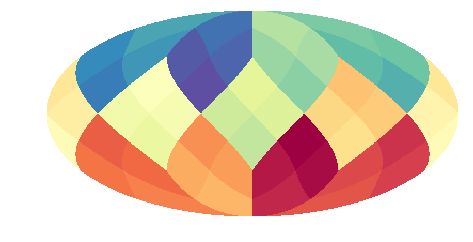

In [11]:
fig = plt.figure(1, figsize=(6,6))
hp.mollview(Fields['pixId'].values+1, fig=1, cmap=plt.cm.Spectral_r, nest=True, title='', cbar=False)


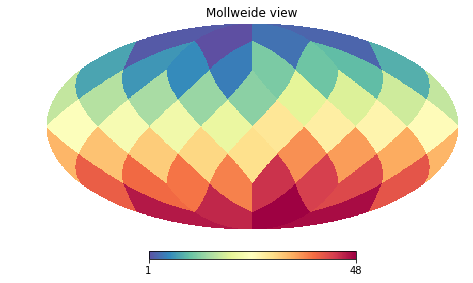

In [12]:
fig = plt.figure(1, figsize=(6,6))
hp.mollview(Fields['pixId'].values+1, fig=1, cmap=plt.cm.Spectral_r, nest=False)

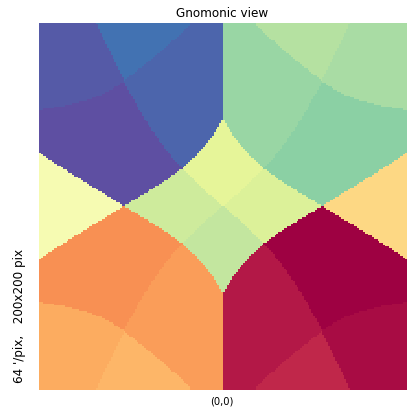

In [13]:
fig = plt.figure(1, figsize=(6,6))
hp.gnomview(Fields['pixId'].values+1, fig=1, cmap=plt.cm.Spectral_r, nest=True, reso=64, cbar=False)


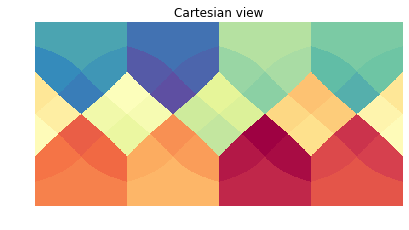

In [14]:
fig = plt.figure(1, figsize=(6,6))
hp.cartview(Fields['pixId'].values+1, fig=1, cmap=plt.cm.Spectral_r, nest=True, cbar=False)


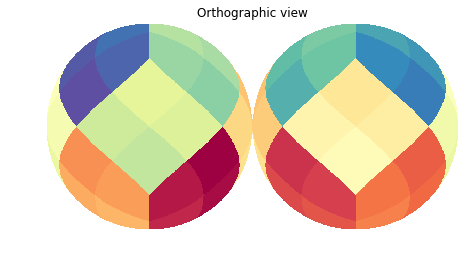

In [15]:
fig = plt.figure(1, figsize=(6,6))
hp.orthview(Fields['pixId'].values+1, fig=1, cmap=plt.cm.Spectral_r, nest=True, cbar=False)


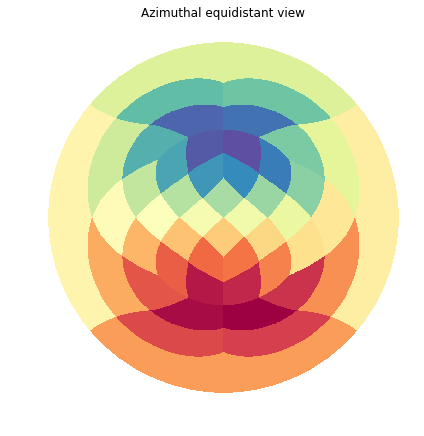

In [16]:
fig = plt.figure(1, figsize=(6,6))
hp.azeqview(Fields['pixId'].values+1, fig=1,reso=30, rot=90, cmap=plt.cm.Spectral_r, nest=False, cbar=False)


#### read Fields.csv

In [17]:
Fields = pd.read_csv("Fields_nside64.csv")
NSIDE = hp.npix2nside(Fields.shape[0])

In [18]:
Fields.head()

,pixId,fieldRa,fieldDec,fieldGl,fieldGb,fieldEl,fieldEb,starDensity_r25
0,0,45.0,89.269029,123.366479,26.508638,88.737376,66.038053,0
1,1,135.0,89.269029,123.629810,27.515401,91.282889,66.037822,0
2,2,225.0,89.269029,122.492534,27.746514,91.337556,67.071334,0
3,3,315.0,89.269029,122.238877,26.737678,88.683896,67.071577,0
4,4,22.5,88.538029,123.203575,25.686667,86.692348,65.965065,0


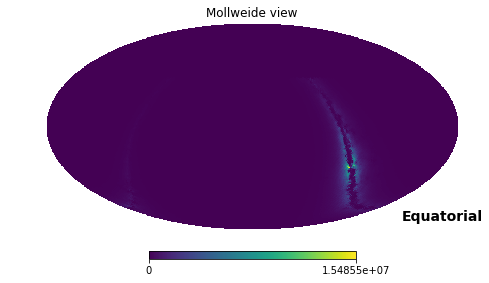

In [19]:
fig = plt.figure(1, figsize=(6,6))
hp.mollview(Fields['starDensity_r25'].values, fig=1, coord=['C'])

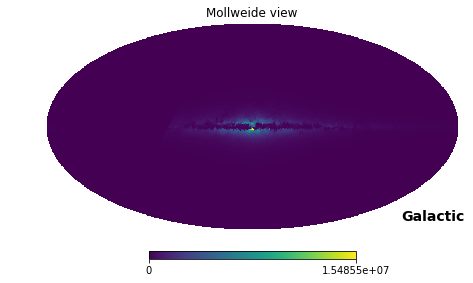

In [20]:
fig = plt.figure(1, figsize=(6,6))
hp.mollview(Fields['starDensity_r25'].values, fig=1, coord=['C', 'G'])
# hp.graticule() # add grid

#### select polygon

In [21]:
def radec2xyz(ra, dec):
    '''convert ra/dec to xyz'''
    theta = 0.5 * np.pi - np.deg2rad(dec)
    phi = np.deg2rad(ra)
    xyz = hp.ang2vec(theta, phi)
    
    return xyz

In [22]:
def get_masked_map(m, pixes, maskpix):
    '''create a masked map,'''
    mx = np.ma.masked_array(m, fill_value=hp.UNSEEN, dtype=np.double)
    #mask=[i in maskpix for i in pixes ]  
    mask = np.isin(pixes, maskpix)
    mx.mask = np.array(mask, dtype=np.bool)
    return mx


In [23]:
## polygon vertices defined by ra, dec in degree
## polygon vertices need to be in order
ra=[0, 60,  30, 330, 300] 
dec=[0, -15,  -45, -45, -15]

# convert to xyz coordinates
xyz = radec2xyz(ra, dec)  
# get masked pixes
ipix_poly = hp.query_polygon(NSIDE, xyz)  


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/healpy/projaxes.py:543: UserWarning: 0.0 180.0 -180.0 180.0
  pmin / dtor, pmax / dtor, mmin / dtor, mmax / dtor
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/healpy/projaxes.py:658: UserWarning: The interval between parallels is 30 deg -0.00'.
  vdeg, varcmin
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/healpy/projaxes.py:666: UserWarning: The interval between meridians is 30 deg -0.00'.
  vdeg, varcmin


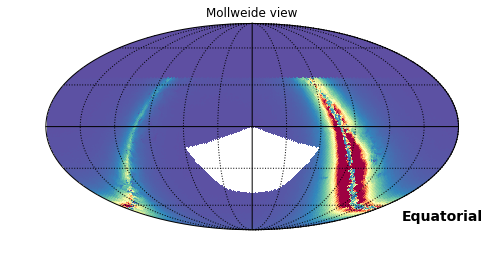

In [24]:
# create a masked map
m = get_masked_map(Fields['starDensity_r25'].values, Fields['pixId'].values, maskpix=ipix_poly) 

# visualize use healpy
fig = plt.figure(1, figsize=(6,6))

hp.mollview(m, fig=1, badcolor='white', coord=['C'], norm='linear', cbar=False, max=1000000, cmap=plt.cm.Spectral_r)
hp.graticule()


In [25]:
# or add mask column to dataframe
# Fields['inpoly'] = [i in ipix_poly for i in Fields['pixId'].values]
Fields['inpoly'] = np.isin(Fields['pixId'].values, ipix_poly)

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/matplotlib/projections/geo.py:421: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


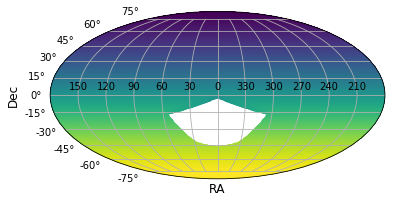

In [26]:
df = Fields
fig, ax = plt.subplots(1, 1, figsize=(6, 6),
                            subplot_kw={'projection': 'mollweide'}); 
slicer = ( df['inpoly'] == False )
df = df[slicer]
x = df['fieldRa']
y = df['fieldDec']
c = df['pixId']
plot_mwd(ax, x, y, c, title='', colorbar=False) 

#### select disc

In [27]:
center = radec2xyz(ra=270, dec=0)
radius = np.deg2rad(20) 
ipix_disc = hp.query_disc(NSIDE, center, radius, inclusive=True)


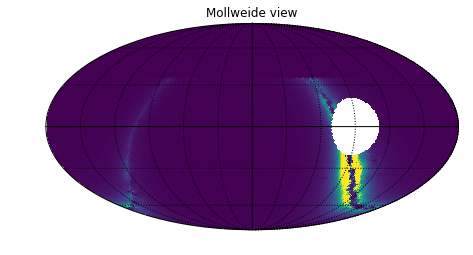

In [28]:
#ipix_disc = np.setdiff1d( Fields['pixId'].values, ipix_disc)
# create a masked map
m = get_masked_map(Fields['starDensity_r25'].values, Fields['pixId'].values, maskpix=ipix_disc) 

# visuzlize
fig = plt.figure(1, figsize=(6,6))
hp.mollview(m, fig=1, badcolor='white', max=2000000, cbar=False)
hp.graticule()

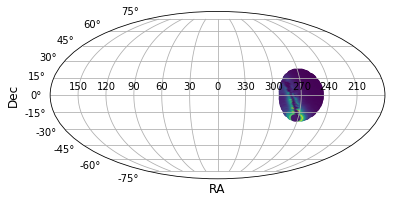

In [29]:
# create a mask column 
Fields['indisc'] = np.isin(Fields['pixId'].values, ipix_disc)
df = Fields
fig, ax = plt.subplots(1, 1, figsize=(6, 6),
                            subplot_kw={'projection': 'mollweide'}); 
slicer = ( df['indisc'] == True ) 
df = df[slicer]
x = df['fieldRa']
y = df['fieldDec']
c = df['starDensity_r25']
plot_mwd(ax, x, y, c, title='', colorbar=False) 


#### query strip

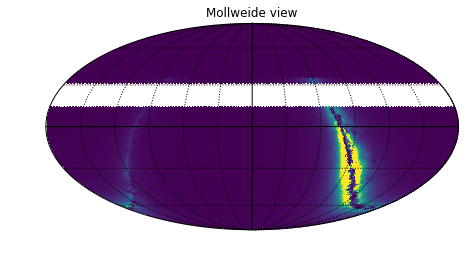

In [30]:
theta1 = np.deg2rad(60)
theta2 = np.deg2rad(75)
ipix_strip = hp.query_strip(NSIDE, theta1=theta1, theta2=theta2,inclusive=True)

#ipix_disc = np.setdiff1d( Fields['pixId'].values, ipix_disc)
# create a masked map
m = get_masked_map(Fields['starDensity_r25'].values, Fields['pixId'].values, maskpix=ipix_strip) 

# visuzlize
fig = plt.figure(1, figsize=(6,6))
hp.mollview(m, fig=1, badcolor='white', max=2000000, cbar=False)
hp.graticule()




#### select circle

In [31]:
center = radec2xyz(ra=90, dec=0)

# define two disks
radius1 = np.deg2rad(6) 
radius2 = np.deg2rad(20) 
disc1 = hp.query_disc(NSIDE, center, radius1, inclusive=False)
disc2 = hp.query_disc(NSIDE, center, radius2, inclusive=False)

# subtract pixels from one another
ipix_ring = np.setdiff1d(disc2, disc1)

In [32]:
ipix_pen = np.concatenate( [ipix_ring, ipix_poly, ipix_disc])

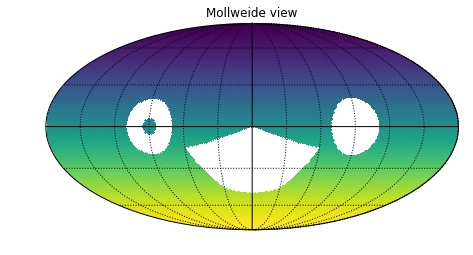

In [33]:
# create a masked map
m = get_masked_map(Fields['pixId'].values, Fields['pixId'].values, maskpix=ipix_pen) 

# visuzlize
fig = plt.figure(1, figsize=(6,6))
hp.mollview(m, fig=1, badcolor='white', cmap=plt.cm.viridis, cbar=False)
hp.graticule()

Text(0, 0.5, '')

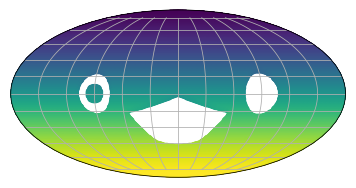

In [34]:
# create a mask column 
Fields['inring'] = np.isin(Fields['pixId'].values, ipix_ring)

df = Fields
fig, ax = plt.subplots(1, 1, figsize=(6, 6),
                            subplot_kw={'projection': 'mollweide'}); 
slicer = ( df['inring'] == False ) & (df['inpoly']==False) & (df['indisc']==False)
df = df[slicer]
x = df['fieldRa']
y = df['fieldDec']
c = df['pixId']
plot_mwd(ax, x, y, c, title='', colorbar=False) 
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')

#### select ellipse

In [35]:
def inellipse(df, p1=[0, 0], p2=[0, 10], dist=10):
    """"check if a pix is inside a ellipsoid
    defined by two focal points: p1, p2, in degree
    and total distance to them: dist, in degree
    return True inside
    """
    p1xyz = radec2xyz(p1[0], p1[1])
    p2xyz = radec2xyz(p2[0], p2[1])
    
    pexyz = radec2xyz(df['fieldRa'], df['fieldDec'])
    
    d1 = np.square( np.sum( (pexyz - p1xyz)**2 ) )
    d2 = np.square( np.sum( (pexyz - p2xyz)**2 ) )
    
    dist = np.deg2rad(dist)
    
    if d1 + d2 <= dist:
        return True
    else:
        return False


In [36]:
Fields['inellipse'] = Fields.apply(inellipse, axis=1, p1=[30, 30], p2=[330, -30], dist=100)


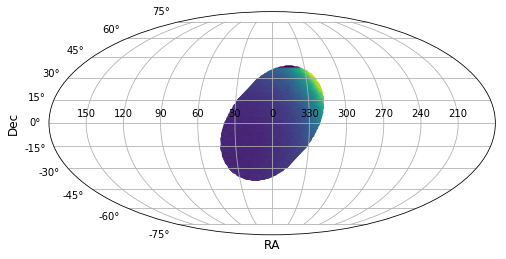

In [37]:
# create a mask column 
df = Fields
fig, ax = plt.subplots(1, 1, figsize=(8, 8),
                            subplot_kw={'projection': 'mollweide'}); 
slicer = ( df['inellipse'] == True )
df = df[slicer]
x = df['fieldRa']
y = df['fieldDec']
c = df['starDensity_r25']
plot_mwd(ax, x, y, c, title='', colorbar=False) 

#### galactic plane

select region by density

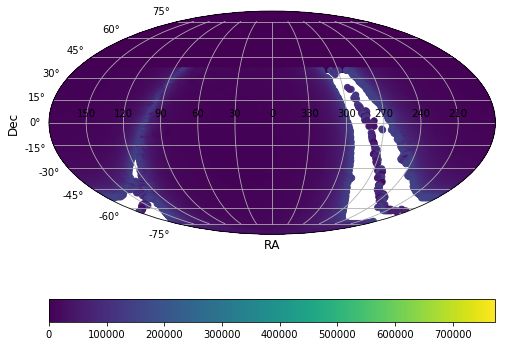

In [38]:
df = Fields

fig, ax = plt.subplots(1, 1, figsize=(8, 8),
                            subplot_kw={'projection': 'mollweide'}); 
maxStarDens = df['starDensity_r25'].max()
# remove high density galactic plane
slicer = ( df['starDensity_r25'] < 0.01 * maxStarDens ) 
df = df[slicer]
x = df['fieldRa']
y = df['fieldDec']
c = df['starDensity_r25']
plot_mwd(ax, x, y, c, title='', colorbar=True, vmax=0.05*maxStarDens ) 


constant width

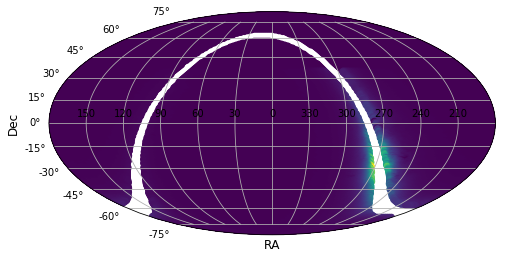

In [39]:
df = Fields

fig, ax = plt.subplots(1, 1, figsize=(8, 8),
                            subplot_kw={'projection': 'mollweide'}); 

# remove by galactic coordinate
slicer = ( df['fieldGb'] > 5 ) | ( df['fieldGb'] < -5 )
df = df[slicer]
x = df['fieldRa']
y = df['fieldDec']
c = df['starDensity_r25']
plot_mwd(ax, x, y, c, title='', colorbar=False) 


**define shape of galactic plane**

In [40]:
def getAvoidanceLatitudes(galL, peakDeg=10., taperDeg=80., constWidth=5.):
    
    """Returns the (positive) GP avoidance region for input galactic longitude
    Input:
        galL: in degree
        peakDeg: galaxy peak size
        taperDeg: half width, in degree
        constWidth: in degree
    return 
        val: the positive galaxy b, in degree
    """  
    # The following is adapted from spatialPlotters.py in sims_maf, method _plot_mwZone
    
    # astropy uses 0 <= glon <= 2pi, so we shift the input values accordingly.
    galL = np.radians(galL)
    galL_use = np.copy(galL)
    gSec = np.where(galL_use > np.pi)
    galL_use[gSec] -= 2.0 * np.pi
    
    peakWidth=np.radians(peakDeg)
    taperLength=np.radians(taperDeg)
    val = peakWidth * np.cos(galL_use / taperLength * np.pi / 2.)
    
    # Remove the cosine peak at anticenter
    gFar = np.where(np.abs(galL_use) > taperLength)[0]
    val[gFar] = 0.

    val += np.radians(constWidth)
    
    return np.rad2deg(val)


In [41]:
# define the shape of galactic plane
peakDeg=15.
taperDeg=90.
constWidth=.5

# get the latitude of galaxy region
Fields['galaxyb'] = getAvoidanceLatitudes(Fields['fieldGl'].values, peakDeg, taperDeg, constWidth)

# check if a field is ingalaxy
Fields['ingalaxy'] = ( Fields['fieldGb'] > -Fields['galaxyb'] ) & ( Fields['fieldGb'] < Fields['galaxyb'] ) 


Text(0, 0.5, 'Gb')

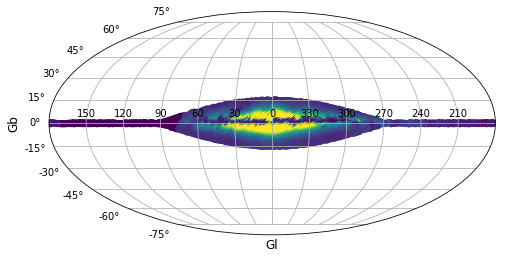

In [42]:
df = Fields

fig, ax = plt.subplots(1, 1, figsize=(8, 8),
                            subplot_kw={'projection': 'mollweide'}); 
slicer = ( df['ingalaxy'])
df = df[slicer]
x = df['fieldGl']
y = df['fieldGb']
c = df['starDensity_r25']
plot_mwd(ax, x, y, c, title='', colorbar=False, vmax=2000000) 
plt.xlabel('Gl') 
plt.ylabel('Gb') 

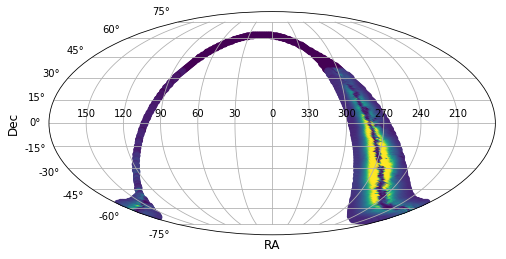

In [43]:
df = Fields

fig, ax = plt.subplots(1, 1, figsize=(8, 8),
                            subplot_kw={'projection': 'mollweide'}); 
slicer = ( df['ingalaxy'])
df = df[slicer]
x = df['fieldRa']
y = df['fieldDec']
c = df['starDensity_r25']
plot_mwd(ax, x, y, c, title='', colorbar=False, vmax=2000000) 


#### ecliptic

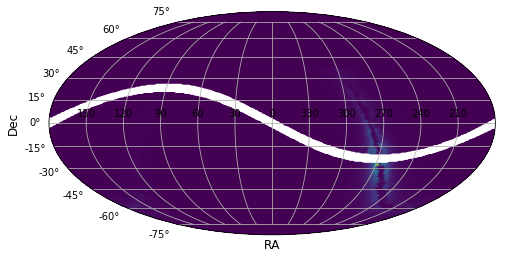

In [44]:
df = Fields

fig, ax = plt.subplots(1, 1, figsize=(8, 8),
                            subplot_kw={'projection': 'mollweide'}); 
slicer = ( df['fieldEb'] > 5 ) | ( df['fieldEb'] < -5 )
df = df[slicer]
x = df['fieldRa']
y = df['fieldDec']
c = df['starDensity_r25']
plot_mwd(ax, x, y, c, title='', colorbar=False) 


#### select pixels use interactive tools

go to [select pixes](http://xiaolng.github.io/xiaolng.github.io/9.html)

In [45]:
#!pip install bokeh

In [46]:
from bokeh.plotting import figure, output_file, show
from bokeh.palettes import Spectral6
from bokeh.transform import linear_cmap
from bokeh.io import output_notebook

# output to static HTML file
# output_file("line.html")
output_notebook()

Loading BokehJS ...

In [47]:
# use a lower resolution map
Fields16 = pd.read_csv("Fields_nside16.csv")

In [48]:
p = figure(plot_width=600, plot_height=400, )

x = Fields16['fieldRa'].values
y = Fields16['fieldDec'].values
# add a circle renderer with a size, color, and alpha

# create a colormap
mapper = linear_cmap(field_name='starDensity_r25', palette=Spectral6 ,
                     low=min(Fields['starDensity_r25']) ,high=0.05*max(Fields['starDensity_r25']))

p.circle('fieldRa', 'fieldDec', source=Fields16, size=20, alpha=0.5, color=mapper)

p.text(x, y, text=Fields16['pixId'].values, text_align='center', text_font_size='3pt')

p.xaxis.axis_label = 'RA'
p.yaxis.axis_label = 'DEC'



In [49]:
#hp.mollzoom(Fields['pixId'].values)

show(p)

In [50]:
#from IPython.core.display import HTML
#HTML('line.html')

In [51]:
ipix_lsst = [
    1067,1066,1130,1194,1258,1195,1323,1386,1451,1514,1579,1642,1707,1835,1770,1834,1833,1832,1831,1899,1898,1897,1896,1895,1316,1379,1443,1506,1570,1633,1698,1762,1827,1891,1828,1764,1701,1637,1252,1188,1123,1059,1060,1124,1189,1253,1317,1380,1444,1507,1571,1634,1699,1763,1700,1636,1573,1187,1250,1314,1122,1186,1249,1322,1450,1578,1706,995,1053,1118,1182,1247,1311,1375,1438,1502,1565,1629,1692,1310,1246,1181,1117,1180,1244,1307,1245,1308,1372,1374,1437,1501,1564,1628,1691,1757,1756,1820,1885,1949,1886,1822,1759,1694,1758,1821,1631,1695,1112,1111,1110,1108,1107,1109,1175,1106,1170,1171,1172,1173,1174,1237,1236,1300,1365,1364,1428,1493,1492,1556,1621,1620,1684,1749,1748,1812,1877,1876,1105,1169,1104,1234,1940,1235,1113,1238,1176,1168
]


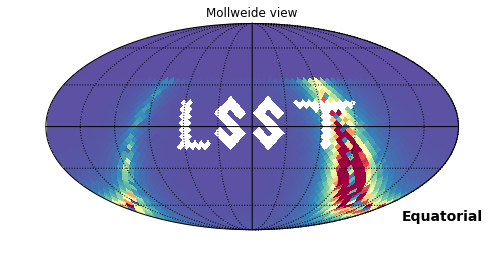

In [69]:
# create a masked map
m = get_masked_map(Fields16['starDensity_r25'].values, Fields16['pixId'].values, maskpix=ipix_lsst) 

# visualize use healpy
fig = plt.figure(1, figsize=(6,6))

hp.mollview(m, fig=1,badcolor='white', coord=['C'], norm='linear', cbar=False, max=1000000, cmap=plt.cm.Spectral_r)
hp.graticule()


#### run on MAF

In [53]:
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db


In [54]:
# load opsim database
dbpath = "/home/idies/workspace/lsst_cadence/FBS_1.4/"  # path to all opsim databases

# connect to opsim database
dbname = 'baseline_v1.4_10yrs.db'
opsdb = db.OpsimDatabase(dbpath+dbname)

# output directory
outDir = 'outDir'
resultsDb = db.ResultsDb(outDir=outDir)


In [55]:
# all column names
opsdb.columnNames

{'Proposal': ['proposalId', 'proposalName', 'proposalType'],
 'SummaryAllProps': ['observationId',
  'fieldRA',
  'fieldDec',
  'observationStartMJD',
  'flush_by_mjd',
  'visitExposureTime',
  'filter',
  'rotSkyPos',
  'numExposures',
  'airmass',
  'seeingFwhm500',
  'seeingFwhmEff',
  'seeingFwhmGeom',
  'skyBrightness',
  'night',
  'slewTime',
  'visitTime',
  'slewDistance',
  'fiveSigmaDepth',
  'altitude',
  'azimuth',
  'paraAngle',
  'cloud',
  'moonAlt',
  'sunAlt',
  'note',
  'fieldId',
  'proposalId',
  'block_id',
  'observationStartLST',
  'rotTelPos',
  'moonAz',
  'sunAz',
  'sunRA',
  'sunDec',
  'moonRA',
  'moonDec',
  'moonDistance',
  'solarElong',
  'moonPhase'],
 'info': ['index', 'Parameter', 'Value']}

include mask inside a metric class

In [56]:
class testMetric(metrics.BaseMetric):
    """metric with mask inside"""
    def __init__(self, colname, nside, pixMask, **kwargs):
        self.colname = colname
        self.nside = nside
        self.pixMask = pixMask
        super().__init__(col=colname, metricDtype='float', **kwargs)
    
    def mask(self, ra, dec):
        """return mask index"""
        # util function to get pixId of that field
        pixIds = RADec2pix(self.nside, ra, dec)
        #print(pixIds)
        mask = np.isin(pixIds, self.pixMask)
        return mask
    
    def run(self, dataSlice, slicePoint=None):
        
        mask = self.mask(dataSlice['fieldRA'], dataSlice['fieldDec'])
        
        # method used to compute metric, return a values for each slicepoint
        data = dataSlice[mask]
        if len(data)!=0:
            result = np.mean(dataSlice[self.colname][mask])  
        else:
            result = hp.UNSEEN
        return result


In [67]:
pixMask = ipix_lsst

# metric, slicer, constraint
metric = testMetric(colname='airmass', nside=16, pixMask=pixMask)
slicer = slicers.HealpixSlicer(nside = 16)
sqlconstraint = 'filter = "r" and night<200'

# bundle
testMetricSky = metricBundles.MetricBundle(metric, slicer, sqlconstraint)

# group bundle
bundleDict = {'testMetricSky':testMetricSky}
group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir = outDir, resultsDb=resultsDb)

# run
group.runAll()
#group.plotAll(closefigs = False)


Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter = "r" and night<200 for columns ['fieldDec', 'fieldRA', 'airmass']
Found 26229 visits
Running:  ['testMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


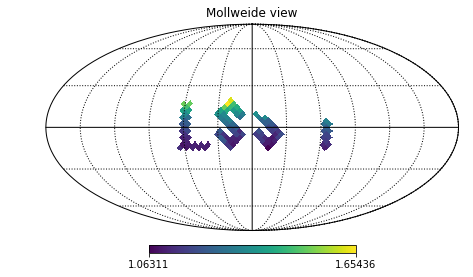

In [68]:
plt.figure(1)
hp.mollview( testMetricSky.metricValues, fig=1, badcolor='white')
hp.graticule()

use UserPointsSlicer, faster

In [59]:
class newMetric(metrics.BaseMetric):
    """simplest metric example"""
    def __init__(self, colname, **kwargs):
        self.colname = colname
        super().__init__(col=colname, metricDtype='float', **kwargs)
        
    def run(self, dataSlice, slicePoint=None):
        
        # method used to compute metric, return a float value for each slicepoint/healpix
        data = dataSlice
        if len(data)!=0:
            result = np.mean(data[self.colname])  
        else:
            result = hp.UNSEEN
        return result


Querying database SummaryAllProps with constraint filter = "r" and night<200 for columns ['fieldDec', 'fieldRA', 'airmass']
Found 26229 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter = "r" and night<200" constraint now.
Plotting complete.


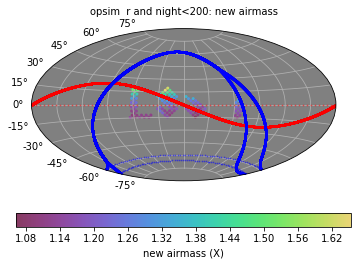

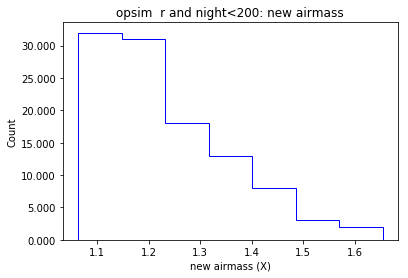

In [70]:
# metric, slicer, constraint
metric = newMetric(colname='airmass',)
# use UserPointsSlicer for
ra, dec = pix2radec(nside=16, ipix=ipix_lsst)
slicer = slicers.UserPointsSlicer(ra, dec, latLonDeg=True, badval=0)
sqlconstraint = 'filter = "r" and night<200'

# bundle
newMetricSky = metricBundles.MetricBundle(metric, slicer, sqlconstraint)

# group bundle
bundleDict = {'newMetricSky':newMetricSky}
group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir = outDir, resultsDb=resultsDb)

# run
group.runAll()
group.plotAll(closefigs = False)


In [71]:
from lsst.sims.utils import _healbin


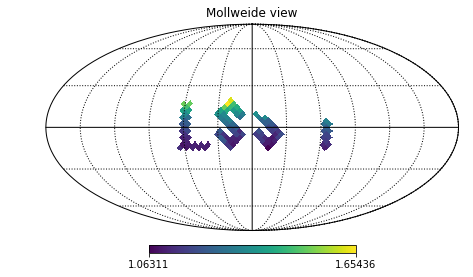

In [73]:
plt.figure(1)
dist = _healbin(slicer.slicePoints['ra'], slicer.slicePoints['dec'], newMetricSky.metricValues, nside=16)
hp.mollview(dist, fig=1, badcolor='white')
hp.graticule()

#### others

In [262]:
from ipywidgets import interactive

In [264]:
def f(min, max):
    plt.figure(2)
    hp.mollview(m, fig=2, min=min, max=max)
    hp.graticule()
    plt.show()

# view density interactively
interactive_plot = interactive(f, min=(0, 100000, 1000), max=(10000, 9010980, 1000))
#output = interactive_plot.children[-1]
#output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=50000, description='min', max=100000, step=1000), IntSlider(value=451000…

#### utils

In [1]:
def plot_mwd(ax, RA, Dec, c, org=0, title='Mollweide projection', projection='mollweide', vmin=None, vmax=None, colorbar=True):
    ''' RA, Dec are arrays of the same length.
    RA takes values in [0,360), Dec in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    
    Examples:
    >>> fig, ax = plt.subplots(1, 1, figsize=(8, 8), 
                            subplot_kw={'projection': 'mollweide'}); 
        plot_mwd(ax, x, y, c, title='') 
    '''
    if vmax is None:
        vmax = c.max()
    if vmin is None:
        vmin = c.min()
    
    x = np.remainder(RA+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    # fig = plt.figure(figsize=(10, 5))
    # ax = fig.add_subplot(111, projection=projection, facecolor ='LightCyan')
    # ax = fig.add_subplot(111, projection=projection, facecolor ='honeydew')
    sc = ax.scatter(np.radians(x), np.radians(Dec), c=c, marker='o', vmin=vmin, vmax=vmax)  # convert degrees to radians
    ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_title(title)
    ax.title.set_fontsize(15)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)
    if colorbar:
        cbar = plt.colorbar(sc, ax=ax, orientation="horizontal")
    #cbar.set_clim(-2.0, 2.0)

# ------------------------------------------------------------------- #
# builtin star density map
# ------------------------ #
import os
import healpy as hp
from lsst.utils import getPackageDir
from scipy.interpolate import interp1d
from lsst.sims.maf.utils import radec2pix

def load_starmap(flt='r'):
    # get mapdir '/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maps/2017.05.08-4-gac432e6/StarMaps'
    mapDir = os.path.join(getPackageDir('sims_maps'),'StarMaps') 

    mapfile = 'starDensity_{}_nside_64.npz'.format(flt)

    starMap = np.load( os.path.join(mapDir, mapfile) )
    
    return starMap
      
def get_starDensity(ra=0, dec=0, starMap=None, mag=25):
    '''get star density of a field, from star density map,
    input ra, dec in degree 
    returns stars / (sq degree)
    '''
    ra = ra * np.pi / 180   # convert to radian
    dec = dec * np.pi / 180

    starMapDensity = starMap['starDensity'].copy()
    starMapBins = starMap['bins'].copy()
    starmapNside = hp.npix2nside( np.size(starMapDensity[:,0]) )
    
    ipix = radec2pix(starmapNside, ra, dec) # convert from ra/dec to ipix 
    density = interp1d( starMapBins[1:], starMapDensity[ipix, :] ) (mag)
    return int( density )

#-----------------------------------
# coordinates transform
def pix2radec(nside, ipix, degree=True):
    """from ipix to ra/dec"""
    
    theta, phi = hp.pix2ang(nside, ipix)
    ra = phi
    dec = np.pi/2. - theta
    if degree:
        ra = np.rad2deg(ra)
        dec = np.rad2deg(dec)
    return ra, dec
    
def radec2ecliptic(ra, dec):
    '''convert from ra/dec to galactic l/b'''
    from astropy.coordinates import GeocentricTrueEcliptic
    from astropy.coordinates import SkyCoord
    from astropy import units as u
    c = SkyCoord(ra=ra, dec=dec, 
                 unit=(u.degree, u.degree))
    
    lon = c.transform_to(GeocentricTrueEcliptic()).lon.degree
    lat = c.transform_to(GeocentricTrueEcliptic()).lat.degree
    
    return lon, lat

def radec2gal(ra, dec):
    '''convert from ra/dec to galactic l/b'''
    from astropy.coordinates import SkyCoord
    from astropy import units as u
    c = SkyCoord(ra=ra, dec=dec, 
                 unit=(u.degree, u.degree))
    
    l = c.galactic.l.degree
    b = c.galactic.b.degree
    return l, b

def gal2radec(gl, gb):
    '''convert gl/gb to ra/dec'''
    from astropy.coordinates import SkyCoord
    from astropy import units as u
    c = SkyCoord(l=gl, b=gb, frame="galactic",
                unit=(u.degree, u.degree))
    ra = c.icrs.ra.degree
    dec = c.icrs.dec.degree
    return ra, dec

# redefined RADec2pix, default in degree 
def RADec2pix(nside, ra, dec, degree=True):
    """
    Calculate the nearest healpixel ID of an RA/Dec array, assuming nside.

    Parameters
    ----------
    nside : int
        The nside value of the healpix grid.
    ra : numpy.ndarray
        The RA values to be converted to healpix ids, in degree by default.
    dec : numpy.ndarray
        The Dec values to be converted to healpix ids, in degree by default.

    Returns
    -------
    numpy.ndarray
        The healpix ids.
    """
    if degree:
        ra = np.radians(ra) # change to radians
        dec = np.radians(dec)
    
    lat = np.pi/2. - dec
    hpid = hp.ang2pix(nside, lat, ra )
    return hpid
